<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/u%2FEiffL%2Fmixture_ramp_bij/notebooks/score_matching/NF_score_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit mixture coupling layers


In [1]:
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability jaxopt
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@u/EiffL/mixture_ramp_bij

     |████████████████████████████████| 287 kB 9.7 MB/s 
     |████████████████████████████████| 126 kB 32.8 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [2]:
d=2
batch_size = 1024

In [3]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import ImplicitRampBijector, MixtureImplicitRampBijector

In [4]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.02, normalized=True)
  #seed = jax.random.PRNGKey(0)  # Uncomment to fix the samples
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

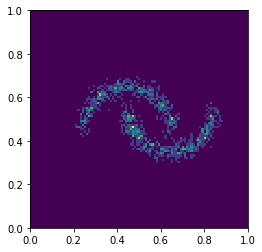

In [5]:
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

In [6]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    n_mixtures = 8
    # NN to get a b and c
    net = hk.Linear(128, name='layer1')(x)
    net = jnp.sin(net)
    net = hk.Linear(128, name='layer2')(net)
    net = jnp.sin(net)
#     net = hk.Linear(256)(net)
#     net = jnp.sin(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_mixtures, name='layer3')(net)) * log_a_bound
    b   = jax.nn.sigmoid(hk.Linear(output_units*n_mixtures, name='layer4')(net))
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_mixtures, name='layer5')(net)) * (1 - min_density_lower_bound)
    p = jax.nn.softmax(hk.Linear(n_mixtures, name='layer6')(net))
    
    return MixtureImplicitRampBijector(lambda x: x**5, 
                                       jnp.exp(log_a).reshape([-1,n_mixtures,output_units]),
                                       b.reshape([-1,n_mixtures,output_units]),
                                       c.reshape([-1,n_mixtures,output_units]),
                                       p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.2*jnp.ones(d), 
                                                0.001,0.999),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [7]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))
model_jac = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse_log_det_jacobian(x)))
model_inv = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse(x)))
model_sample = hk.without_apply_rng(hk.transform(lambda : Flow()().sample(1024, seed=next(rng_seq))))

In [8]:
rng_seq = hk.PRNGSequence(12)
params = model_NF.init(next(rng_seq), jnp.zeros([batch_size,d]))

logdet (1024, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1024, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


In [9]:
# # TO DO
#@jax.jit
def loss1_fn(params, batch, score):
  log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  return -jnp.mean(log_prob)

# @jax.jit
# def loss_fn(params, batch, score):
#   out = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
#   return jnp.mean( jnp.sum((out - score)**2, axis=1))

#@jax.jit
def loss2_fn(params, batch, score):
#   log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
  return -jnp.mean(log_prob) # jnp.mean( jnp.sum((out - score)**2, axis=1))/1000jax.value_and_grad

In [13]:
g1 = jax.grad(lambda p:loss1_fn(p, batch, score))(params)

logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


In [14]:
g2 = jax.grad(lambda p:loss2_fn(p, batch, score))(params)

logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


In [15]:
g1['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[ 0.00623824, -0.01564069, -0.01739116,  0.01224523,
              -0.00651678,  0.01142012,  0.00812302,  0.01227474,
               0.01773459,  0.00314177]], dtype=float32)

In [16]:
g2['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[ 0.00118488, -0.00964262, -0.01894116,  0.01168651,
              -0.00615255,  0.01007015,  0.00577893,  0.01240795,
               0.01435342,  0.00449036]], dtype=float32)

In [ ]:
params['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[ 0.18158716,  0.6225872 ,  0.91571075,  1.6014925 ,
              -1.440559  , -0.6829792 ,  0.54838717,  0.1963539 ,
               0.06737389,  1.3469422 ]], dtype=float32)

In [10]:
#@jax.jit
def loss_fn(params, batch, score):
  log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  return -jnp.mean(log_prob)

In [ ]:
# def loss_fn(params, batch, score):
# #   log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
#   log_prob, out = jax.vmap(jax.value_and_grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
#   return -jnp.mean(log_prob) + jnp.mean( jnp.sum((out - score)**2, axis=1))/1000.

In [ ]:
# @jax.jit
# def loss_fn(params, batch, score):
#   out = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
#   return jnp.mean( jnp.sum((out - score)**2, axis=1))/1000.0

In [20]:
learning_rate=0.0002
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [12]:
@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [13]:
losses = []
master_seed = hk.PRNGSequence(0)

In [21]:
for step in tqdm(range(10000)):
    batch, score = get_batch(next(master_seed))
    l, params, opt_state = update(params, opt_state, batch, score)
    losses.append(l)

100%|██████████| 10000/10000 [03:02<00:00, 54.71it/s]


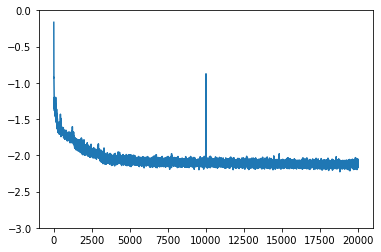

In [22]:
ylim(-3,0)
plot(losses[:])

logdet (16384, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (16384, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


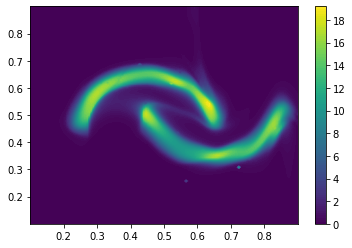

In [23]:
# with gradients
x = (jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,128),
                           jnp.linspace(0.1,0.9,128)),-1) )

im = model_NF.apply(params, x.reshape(-1,2)).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im),100); colorbar()

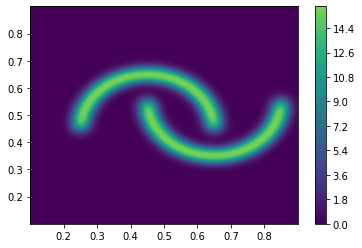

In [24]:
contourf(x[...,0],x[...,1],get_two_moons(sigma= 0.02, normalized=True).prob(x),100,vmax=20); colorbar()

In [47]:
X = np.arange(-1.5, 2.5, 0.1) / 5 + 0.45
Y = np.arange(-1, 1.5, 0.1) / 5 + 0.45
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2)) 

# Getting value of the log prob and score for the true distribution
logp = get_two_moons(sigma=0.02, normalized=True).prob(points).reshape([len(Y), len(X)])
true_score = jax.vmap(jax.grad(lambda x: get_two_moons(sigma=0.02, normalized=True).log_prob(x)))(points).reshape([len(Y), len(X), 2])

# Getting value of the score as predicted by the NN
pred_fn = model_NF.apply(params, points).reshape([len(Y), len(X)])
pred_score = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(points).reshape([len(Y), len(X),2])

logdet (1000, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1000, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


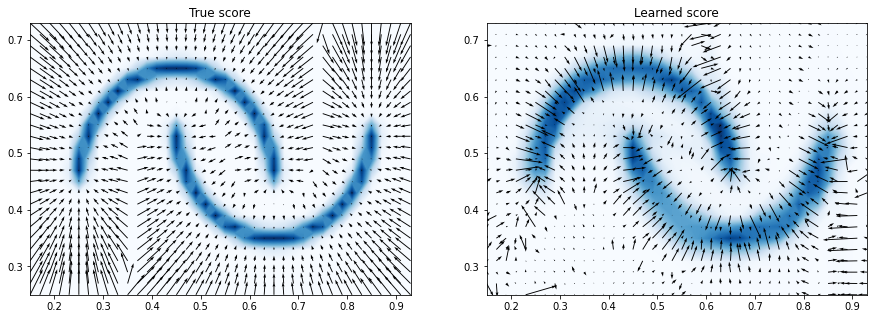

In [51]:
figure(figsize=[15,5])
subplot(121)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, true_score[:,:,0], true_score[:,:,1], scale=7500);
title('True score')

subplot(122)
contourf(X,Y,exp(pred_fn), 256, cmap='Blues')
quiver(X, Y, pred_score[:,:,0], pred_score[:,:,1]);
title('Learned score');

In [27]:
x = model_inv.apply(params, batch)

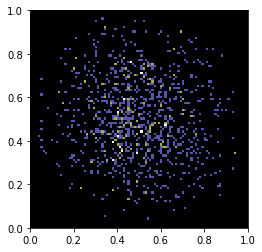

In [28]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]],cmap='gist_stern');gca().set_aspect('equal');

In [29]:
x = model_sample.apply(params)

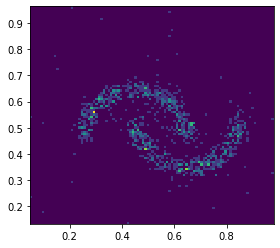

In [30]:
hist2d(x[:,0], x[:,1],100);gca().set_aspect('equal');

In [31]:
coupl = hk.without_apply_rng(hk.transform(lambda x: CustomCoupling(name = 'b2')(x,1)))

In [32]:
predicate = lambda module_name, name, value: 'flow/b2' in module_name
params_b1 = hk.data_structures.filter(predicate, params) 

In [33]:
params_b1=hk.data_structures.to_mutable_dict(params_b1)
params_b1={k.split('flow/')[1]:params_b1[k] for k in params_b1.keys()}

In [40]:
t = jnp.linspace(0.01,0.99,256)
bij = coupl.apply(params_b1, t.reshape([256,1]))

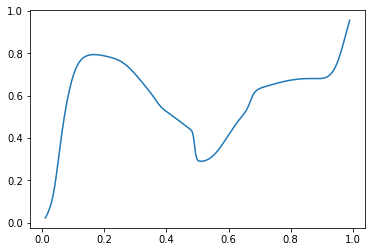

In [41]:
plot(t,bij(t.reshape([256,1])))

In [42]:
inv = bij.inverse(1*bij(t))

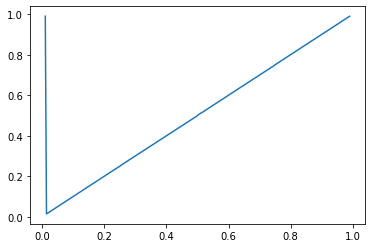

In [43]:
plot(t,inv)

logdet (256, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


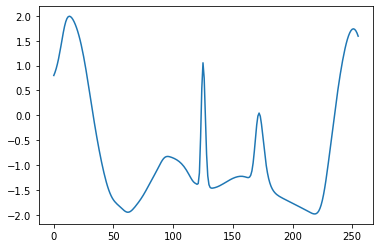

In [45]:
plot(bij.forward_log_det_jacobian(t.reshape([256,1])))

logdet (256, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


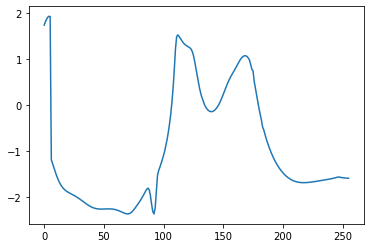

In [46]:
plot(bij.inverse_log_det_jacobian(t.reshape([256,1])))